## Part 1 - Notebook Setup and Authentication

In [1]:
# General dependencies

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import time
from datetime import datetime, date, timedelta
import sys

# For Twitter API extraction
import tweepy
#!pip install python-dotenv
from dotenv import load_dotenv

# Tweet pre-processor
import preprocessor as p

# NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# TextBlob
from textblob import TextBlob

# FLairNLP
from flair.models import TextClassifier
from flair.data import Sentence

# Stanza
# import stanza
# stanza.download('en')

# Stanford CoreNLP
from pycorenlp import StanfordCoreNLP

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fvaladrien/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2021-10-01 19:28:47 INFO: Downloading default packages for language: en (English)...
2021-10-01 19:28:48 INFO: File exists: /Users/fvaladrien/stanza_resources/en/default.zip.
2021-10-01 19:28:51 INFO: Finished downloading models and saved to /Users/fvaladrien/stanza_resources.


In [2]:
# Read in CSV file in from the resources folder into a Pandas DataFrame
# Set the date as the DateTimeIndex
tweets_df = pd.read_csv(
    Path('Inflation_Tweets_16_21.csv'),
    index_col = "date", 
    parse_dates = True, 
    infer_datetime_format = True
)

# Review the DataFrame
tweets_df.head()

,Unnamed: 0,tweet,hashtags,user_id,username,name,nlikes,nreplies,nretweets
date,,,,,,,,,
2016-12-30 14:33:37,0,"25 years ago, Putin drew a key lesson from the...",[],3108351,WSJ,The Wall Street Journal,135,12,112
2016-12-23 19:26:55,1,"The markets say inflation is coming, but the d...",[],3108351,WSJ,The Wall Street Journal,44,11,52
2016-12-14 19:17:06,2,The Fed said its rate increase came “in view o...,[],3108351,WSJ,The Wall Street Journal,34,10,51
2016-12-14 18:24:05,3,Inflation has picked the perfect time to make ...,[],3108351,WSJ,The Wall Street Journal,35,2,30
2016-12-08 23:10:29,4,China’s consumer inflation picked up for a thi...,[],3108351,WSJ,The Wall Street Journal,32,2,25


# Text Pre-processing
Using tweet-preprocessor Python package (https://pypi.org/project/tweet-preprocessor/) pip install tweet-preprocessor

Preprocessor is a preprocessing library for tweet data written in Python. Currently supports # cleaning, tokenizing and parsing: URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys

In [3]:
# If Primary Dataframe is not already called "tweets_df" use below line to conform to the naming convention used on the cells to come
# tweets_df = 'Put you df name here'.copy()

In [4]:
# Convert all tweet text to lowercase
# tweets_df['text'] = tweets_df['text'].apply(lambda x: str(x.lower()))

# Note, skipping this step as uppercase reflects sentiments

In [5]:
# Clean tweet text with tweet-preprocessor
tweets_df['text_cleaned'] = tweets_df['tweet'].apply(lambda x: p.clean(x))
tweets_df.tail()

,Unnamed: 0,tweet,hashtags,user_id,username,name,nlikes,nreplies,nretweets,text_cleaned
date,,,,,,,,,,
2021-09-14 08:32:01,35,Gold futures head lower as investors watch for...,[],624413,MarketWatch,MarketWatch,7,3,6,Gold futures head lower as investors watch for...
2021-09-14 08:15:51,36,Coming at 8:30 a.m. Eastern: latest U.S. infla...,[],624413,MarketWatch,MarketWatch,10,4,3,Coming at :30 a.m. Eastern: latest U.S. inflat...
2021-09-14 07:28:23,37,Treasury yields move higher ahead of inflation...,[],624413,MarketWatch,MarketWatch,8,0,1,Treasury yields move higher ahead of inflation...
2021-09-14 06:54:46,38,The biggest burst of U.S. inflation in several...,[],624413,MarketWatch,MarketWatch,13,4,5,The biggest burst of U.S. inflation in several...
2021-09-14 06:29:37,39,One of the best ways to fight inflation is jus...,[],624413,MarketWatch,MarketWatch,11,5,0,One of the best ways to fight inflation is jus...


In [6]:
tweets_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
tweets_df.head()

,tweet,hashtags,user_id,username,name,nlikes,nreplies,nretweets,text_cleaned
date,,,,,,,,,
2016-12-30 14:33:37,"25 years ago, Putin drew a key lesson from the...",[],3108351,WSJ,The Wall Street Journal,135,12,112,"years ago, Putin drew a key lesson from the So..."
2016-12-23 19:26:55,"The markets say inflation is coming, but the d...",[],3108351,WSJ,The Wall Street Journal,44,11,52,"The markets say inflation is coming, but the d..."
2016-12-14 19:17:06,The Fed said its rate increase came “in view o...,[],3108351,WSJ,The Wall Street Journal,34,10,51,The Fed said its rate increase came in view of...
2016-12-14 18:24:05,Inflation has picked the perfect time to make ...,[],3108351,WSJ,The Wall Street Journal,35,2,30,Inflation has picked the perfect time to make ...
2016-12-08 23:10:29,China’s consumer inflation picked up for a thi...,[],3108351,WSJ,The Wall Street Journal,32,2,25,Chinas consumer inflation picked up for a thir...


In [7]:
# Remove duplicate tweets
tweets_df.drop_duplicates(subset='text_cleaned', keep="first", inplace = True)
len(tweets_df)

951

In [8]:
# Remove unnecessary characters
# Note: Need to remove % as Stanford CoreNLP annotation encounters error if text contains some of these characters
punct =['%','/',':','\\','&amp;','&',';', '<', '>', '@']

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

tweets_df['text_cleaned'] = tweets_df['text_cleaned'].apply(lambda x: remove_punctuations(x))

In [10]:
tweets_df.head()

,tweet,hashtags,user_id,username,name,nlikes,nreplies,nretweets,text_cleaned
date,,,,,,,,,
2016-12-30 14:33:37,"25 years ago, Putin drew a key lesson from the...",[],3108351,WSJ,The Wall Street Journal,135,12,112,"years ago, Putin drew a key lesson from the So..."
2016-12-23 19:26:55,"The markets say inflation is coming, but the d...",[],3108351,WSJ,The Wall Street Journal,44,11,52,"The markets say inflation is coming, but the d..."
2016-12-14 19:17:06,The Fed said its rate increase came “in view o...,[],3108351,WSJ,The Wall Street Journal,34,10,51,The Fed said its rate increase came in view of...
2016-12-14 18:24:05,Inflation has picked the perfect time to make ...,[],3108351,WSJ,The Wall Street Journal,35,2,30,Inflation has picked the perfect time to make ...
2016-12-08 23:10:29,China’s consumer inflation picked up for a thi...,[],3108351,WSJ,The Wall Street Journal,32,2,25,Chinas consumer inflation picked up for a thir...


# Sentiment Analysis


In [11]:
# Define function to get value counts
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(tweets_df[col_name].value_counts())
    percentage = pd.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

# Part 1A - Sentiment Analysis with NLTK Vader
Natural Learning Toolkit (NLTK) is a Python package that offers programs supporting natural language processing (NLP). In addition to its text corpus, it also comes with pre-trained models. In particular, we will be using the Valence Aware Dictionary and sEntiment Reasoner (VADER) model, which is a lexicon and rule-based sentiment analysis tool specifically aimed at sentiment analysis of social media text. It uses a bag of words approach with simple heuristics (such as increasing sentiment intensity in presence of certain words like "very" or "really").

After installing NLTK with the command pip install nltk, we can run sentiment analysis using VADER with these lines of code:

In [12]:
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
tweets_df['nltk_scores'] = tweets_df['text_cleaned'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
tweets_df['nltk_cmp_score'] = tweets_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

In [13]:
neutral_thresh = 0.05

In [14]:
# Categorize scores into the sentiments of positive, neutral or negative
tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

# Neutral score = 0
# tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c > 0 else ('Negative' if c < 0 else 'Neutral'))

In [15]:
tweets_df['nltk_cmp_score'].describe()

count    951.000000
mean       0.038162
std        0.372200
min       -0.896500
25%       -0.175400
50%        0.000000
75%        0.296000
max        0.943700
Name: nltk_cmp_score, dtype: float64

In [16]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,275,28.92,NLTK Vader
1,Neutral,326,34.28,NLTK Vader
2,Positive,350,36.80,NLTK Vader


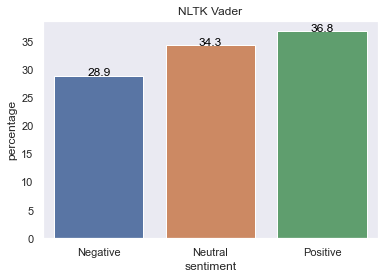

In [17]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

# Part 1B - Sentiment Analysis with TextBlob
TextBlob is a popular Python library used to process textual data and perform a range of NLP tasks including sentiment analysis. Similar to NLTK Vader, the TextBlob sentiment classifier is also based on a bag of words approach. In fact, TextBlob is built upon the NLTK and pattern libraries.

This is the command to install TextBlob: pip install textblob

The NaiveBayesAnalyzer is trained on movies review dataset, so I will be using the default PatternAnalyzer instead




In [19]:
# Obtain polarity scores generated by TextBlob
tweets_df['textblob_score'] = tweets_df['text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [20]:
neutral_thresh = 0.05

In [21]:
# Convert polarity score into sentiment categories
tweets_df['textblob_sentiment'] = tweets_df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

# Neutral score = 0
#tweets_df['textblob_sentiment'] = tweets_df['textblob_score'].apply(lambda c: 'Positive' if c > 0 else ('Negative' if c < 0 else 'Neutral'))


In [22]:
tweets_df['textblob_score'].describe()

count    951.000000
mean       0.066343
std        0.202665
min       -0.800000
25%        0.000000
50%        0.000000
75%        0.150000
max        1.000000
Name: textblob_score, dtype: float64

In [23]:
textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob')
textblob_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,132,13.88,TextBlob
1,Neutral,447,47.00,TextBlob
2,Positive,372,39.12,TextBlob


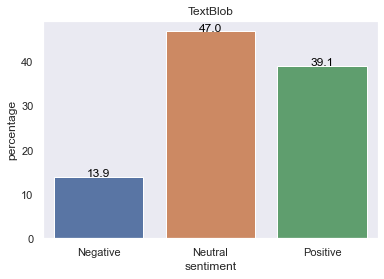

In [24]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
ax.set_title('TextBlob')

for index, row in textblob_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

# Part 2 - Insights from Sentiment Analyses
We will focus on the results from NLTK VADER and TextBlob because they are:

Trained on at least 1 social media dataset Able to give at least 3 classes of sentiments i.e. Positive, Neutral, Negative

In [33]:
df_sentiments = pd.concat([nltk_sentiment_df, 
                           textblob_sentiment_df,
                          ]).reset_index(drop=True)
df_sentiments

,sentiment,counts,percentage,analyzer
0,Negative,275,28.92,NLTK Vader
1,Neutral,326,34.28,NLTK Vader
2,Positive,350,36.80,NLTK Vader
3,Negative,132,13.88,TextBlob
4,Neutral,447,47.00,TextBlob
5,Positive,372,39.12,TextBlob


In [34]:
df_sentiments_pivot = df_sentiments.pivot(index='sentiment', columns='analyzer', values='percentage')
df_sentiments_pivot

analyzer,NLTK Vader,TextBlob
sentiment,,
Negative,28.92,13.88
Neutral,34.28,47.00
Positive,36.80,39.12


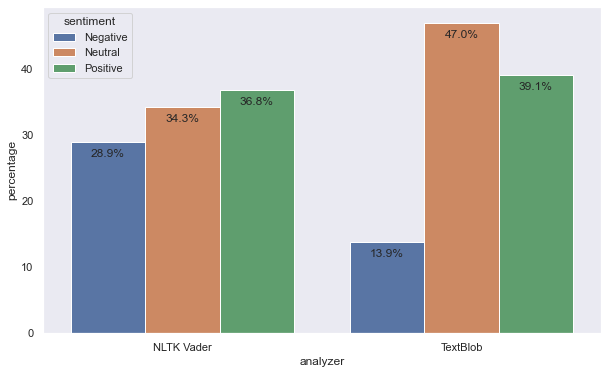

In [35]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="analyzer", y="percentage",
                 hue="sentiment", data=df_sentiments)

# Display annotations
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# Part 3 - Composite Sentiment with Ensemble Method¶
Average Score Take average of the 2 sentiment scores of NLTK Vader and TextBlob

In [36]:
# Make use of sentiments from NLTK Vader and TextBlob 
tweets_df['composite_score'] =  (tweets_df['nltk_cmp_score'] 
                                + tweets_df['textblob_score'])/2

In [37]:
tweets_df['composite_score'].describe()

count    951.000000
mean       0.052252
std        0.237242
min       -0.685950
25%       -0.083333
50%        0.000000
75%        0.201350
max        0.834850
Name: composite_score, dtype: float64

In [38]:
# Threshold for neutral sentiment
neutral_thresh = 0.05

In [40]:
# Convert average sentiment score (from all  analyzers) into sentiment categories
tweets_df['composite_vote_2'] = tweets_df['composite_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [41]:
inflation_composite_sentiment_df = get_value_counts('composite_vote_2','Composite Sentiment')
inflation_composite_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,277,29.13,Composite Sentiment
1,Neutral,255,26.81,Composite Sentiment
2,Positive,419,44.06,Composite Sentiment


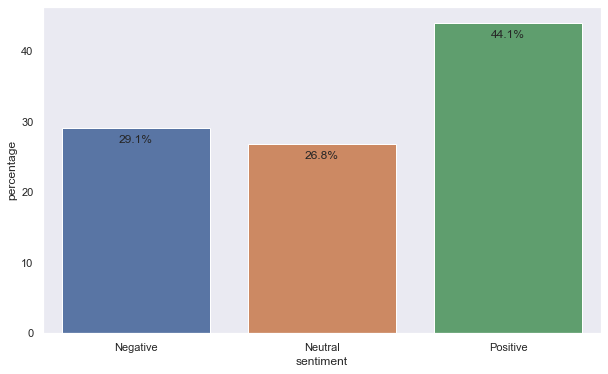

In [43]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="sentiment", y="percentage",
                 data=inflation_composite_sentiment_df)

# Display annotations
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')